###### Inicialização

In [1]:
!pip install meteostat yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 104.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 9.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
  

In [2]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from meteostat import Point, Daily
plt.rcParams["figure.figsize"] = (22,6)

import yfinance as yf
yf.pdr_override()

In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Análise de Séries temporais (Sessão 1)



## Introdução

Dados de séries temporais são registros sequênciais no tempo. Eles são muito comuns e você pode encontrá-los em quase todas as áreas.

#### Definição formal
- Um conjunto sequencial de eventos, ordenados no tempo
- $X_{t}, t = 0,1,2,3,4…$
- Onde $t$ é uma variável que representa o instante de tempo
- Uma série temporal pode conter informação de tedência, efeitos sazonais e ocasionais nos seus dados

A suposição básica que norteia a análise de séries temporais é que há um sistema causal
mais ou menos constante, relacionado com o tempo, que exerceu influência sobre os dados no
passado e pode continuar a fazê-lo no futuro. Este sistema causal costuma atuar criando **padrões
não aleatórios** que podem ser detectados em um gráfico da série temporal, ou mediante algum outro
processo estatístico.

O objetivo da análise de séries temporais é identificar padrões não aleatórios na série
temporal de uma variável de interesse, e a observação deste comportamento passado pode permitir
fazer previsões sobre o futuro, **orientando a tomada de decisões**.

#### 0. Componente temporal

In [4]:
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

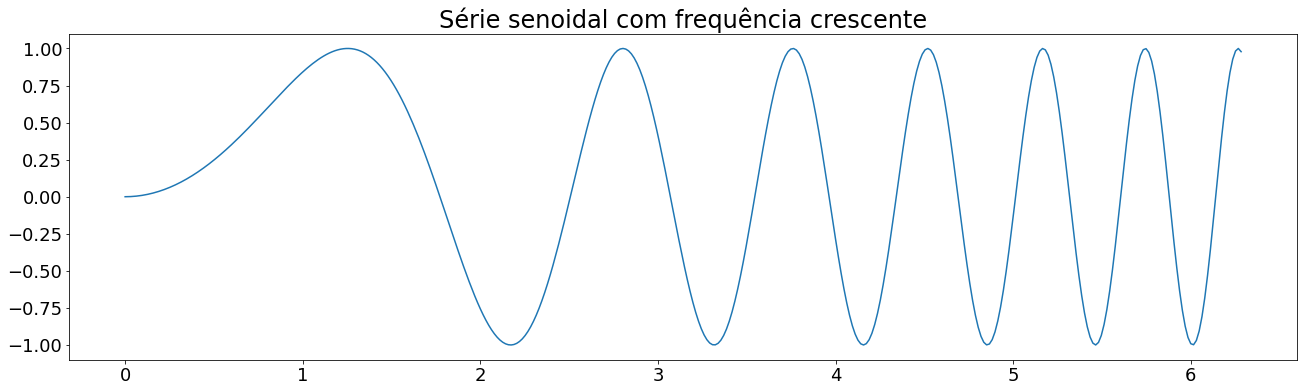

In [5]:
plt.title("Série senoidal com frequência crescente")
_ = plt.plot(x, y)

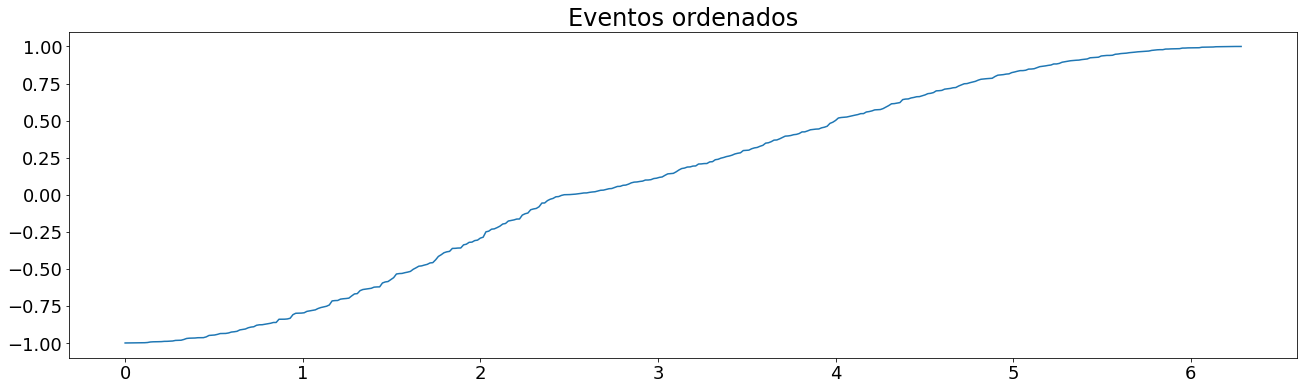

In [6]:
plt.title("Eventos ordenados")
sort_y = np.sort(y)
_ = plt.plot(x, sort_y)

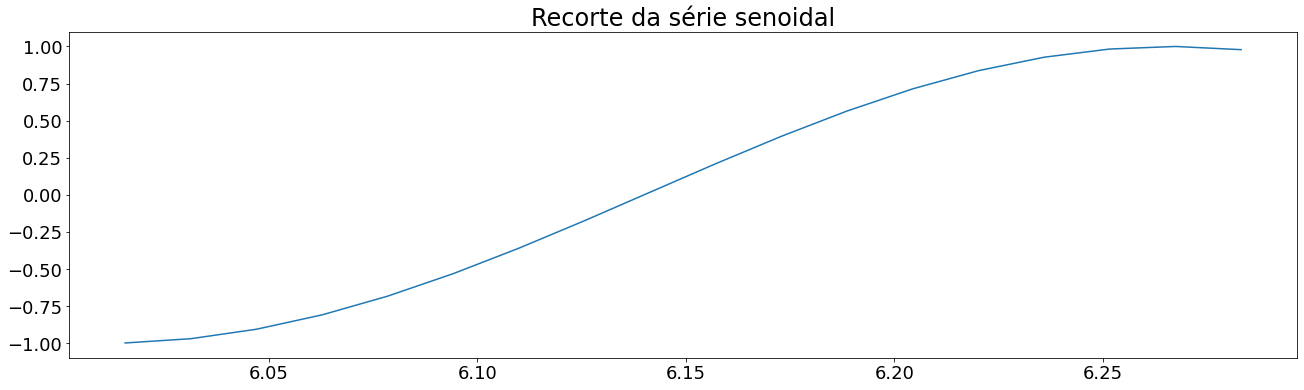

In [9]:
plt.title("Recorte da série senoidal")
pedaco = -18
_ = plt.plot(x[pedaco:], y[pedaco:])

#### 1. Temperatura

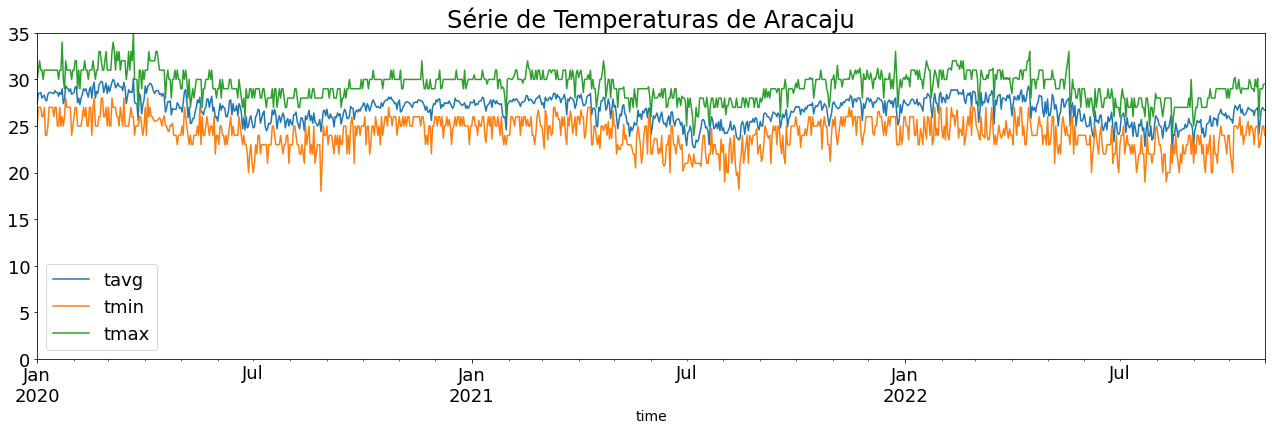

In [10]:
inicio = datetime(2020, 1, 1)
fim = datetime(2022, 10, 31)

local = Point(-11.0056387, -37.2432436) #Aracaju

#Capturando os dados
aracaju = Daily(local, inicio, fim)
serie_aracaju = aracaju.fetch()

ax = serie_aracaju.plot(y=['tavg', 'tmin', 'tmax'], title="Série de Temperaturas de Aracaju", ylim = (0,35))

#### 2. Velocidade do Vento

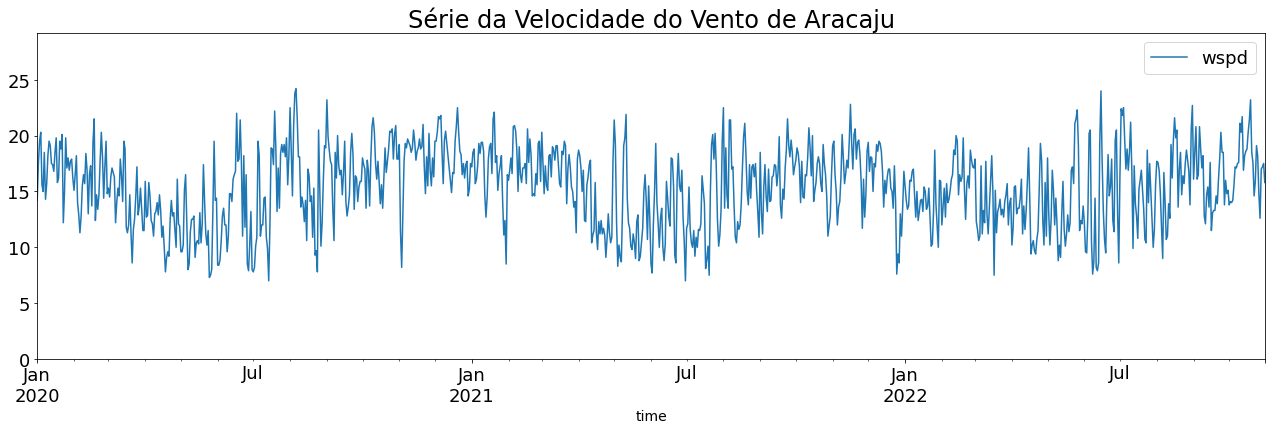

In [11]:
_ = serie_aracaju.plot(y=['wspd'], title="Série da Velocidade do Vento de Aracaju", ylim = (0, serie_aracaju.wspd.max()+5))

#### 3. Câmbio Dólar/Real

In [12]:
serie_dolar = pdr.get_data_yahoo("USDBRL=X", start="2007-01-01", end="2022-12-31")

[*********************100%***********************]  1 of 1 completed


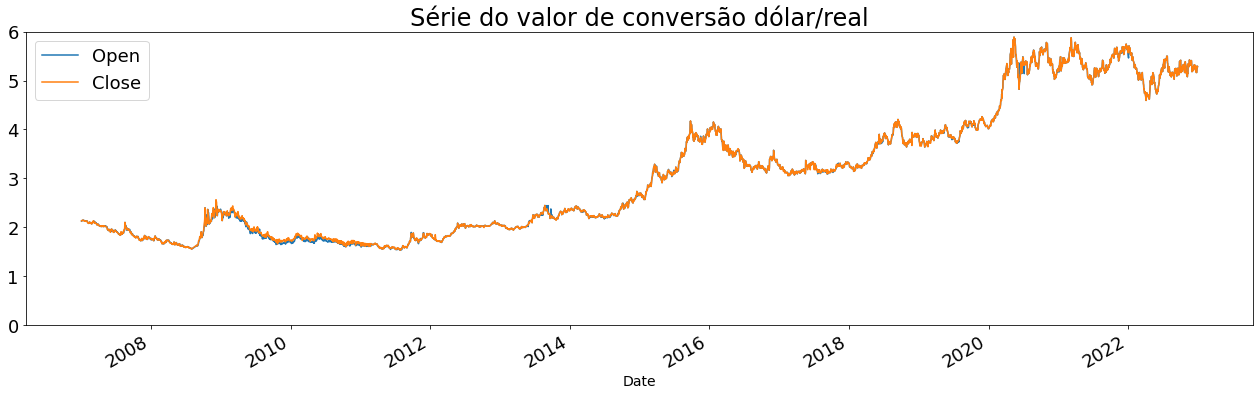

In [13]:
_ = serie_dolar.plot(y=['Open','Close'], title="Série do valor de conversão dólar/real", ylim=(0,6))

#### 4. Inflação (IPCA)

In [14]:
def consulta_bc(codigo_bcb):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

In [15]:
ipca = consulta_bc(433)

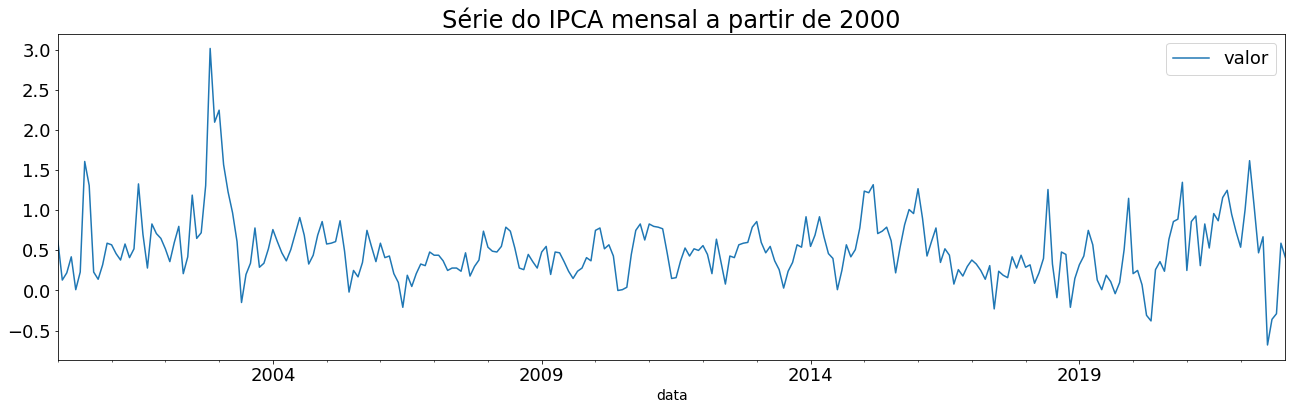

In [16]:
_ = ipca[ipca.index >= '2000-01-01'].plot(title="Série do IPCA mensal a partir de 2000")

#### 5. Nossa voz

In [17]:
# all imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

In [18]:
voz = record()

<IPython.core.display.Javascript object>

In [19]:
voz

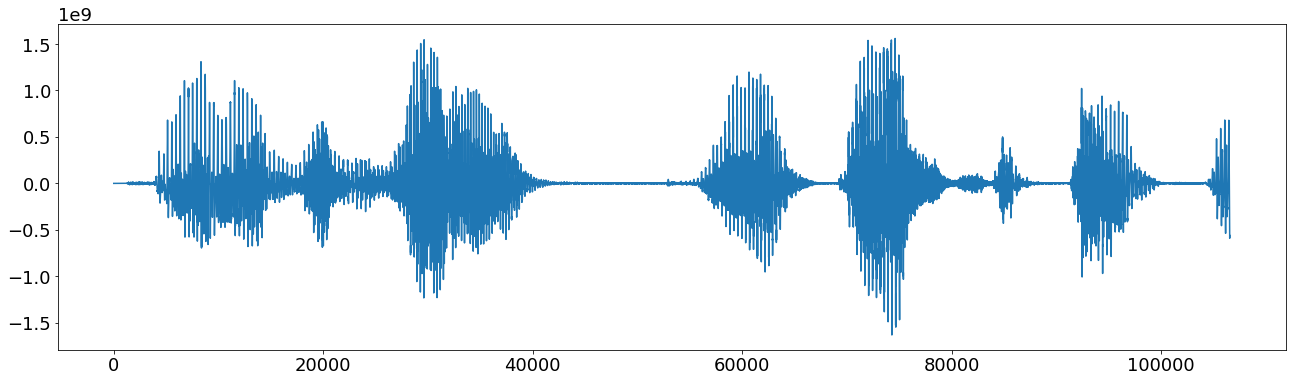

In [20]:
_ = pd.Series(voz.get_array_of_samples()).plot()

#### 6. Outros Exemplos

- Volume de compras em uma loja virtual
- Quantidade de acessos a um portal web
- Percentual de vacância de um depósito
- Gasolina gasta pelos caminhões da frota

## Exercício:

1. O que acontece se reordenarmos os dados da gravação da nossa voz?
2. Crie uma visualização das séries de temperatura diária máxima, média e mínima da sua cidade.
3. Agrupe essa série para criar uma visualização mensal e uma semanal.
4. Qual o dia em que o dolar/real obteve a maior diferença de preço entre abertura e fechamento?
5. Qual a data que obtivemos a maior taxa de inflação?
6. Calcule a inflação anualizada.